# Conversor de Imagens: Espaços de Cor e Formatos

Este notebook implementa um conversor completo de imagens com suporte para diferentes espaços de cor e formatos, incluindo análise comparativa de qualidade e tamanho

### 1. Instalação e Importação de Bibliotecas

In [288]:
# Instalar bibliotecas necessárias
!pip install opencv-python pillow scikit-image matplotlib seaborn

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import color, metrics
import os
import io
from google.colab import files
import pandas as pd
from datetime import datetime
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
warnings.filterwarnings('ignore')

# Configurar matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

### 2. Funções de Upload e Utilidades

In [289]:
def upload_image():
    """Fazer upload de uma imagem do computador local"""
    print("Faça upload de uma imagem...")
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        print(f"Imagem '{filename}' carregada com sucesso!")
        return filename
    else:
        print("Nenhuma imagem foi carregada.")
        return None

In [290]:
def load_image(path):
    """Carregar imagem usando PIL"""
    return Image.open(path)

In [291]:
def get_image_properties(image_path):
    """Extrair propriedades da imagem"""
    img_pil = Image.open(image_path)
    img_cv2 = cv2.imread(image_path)

    properties = {
        'Formato': img_pil.format,
        'Modo': img_pil.mode,
        'Dimensões (L x A)': f"{img_pil.width} x {img_pil.height}",
        'Tamanho (pixels)': img_pil.width * img_pil.height,
        'Canais': len(img_pil.getbands()),
        'Tamanho do arquivo (KB)': os.path.getsize(image_path) / 1024,
        'Profundidade de bits': img_cv2.dtype
    }

    return properties

In [292]:
def display_properties(properties):
    """Exibir propriedades em formato tabular"""
    df = pd.DataFrame(list(properties.items()), columns=['Propriedade', 'Valor'])
    print("\n📊 PROPRIEDADES DA IMAGEM:")
    print("="*50)
    for _, row in df.iterrows():
        print(f"{row['Propriedade']:<25} {row['Valor']}")
    print("="*50)

### 3. Conversores de Espaço de Cor

In [293]:
class ColorSpaceConverter:
    """Classe para converter entre diferentes espaços de cor"""

    @staticmethod
    def rgb_to_cmyk(rgb_image):
        """Converter RGB para CMYK"""
        # Normalizar valores RGB para [0, 1]
        rgb_normalized = np.array(rgb_image).astype(float) / 255.0

        # Extrair canais R, G, B
        r, g, b = rgb_normalized[:,:,0], rgb_normalized[:,:,1], rgb_normalized[:,:,2]

        # Calcular K (Key/Black)
        k = 1 - np.max(rgb_normalized, axis=2)

        # Evitar divisão por zero
        with np.errstate(divide='ignore', invalid='ignore'):
            c = (1 - r - k) / (1 - k)
            m = (1 - g - k) / (1 - k)
            y = (1 - b - k) / (1 - k)

        # Lidar com casos onde k = 1
        c[k == 1] = 0
        m[k == 1] = 0
        y[k == 1] = 0

        # Empilhar canais CMYK
        cmyk = np.stack([c, m, y, k], axis=2)

        return (cmyk * 255).astype(np.uint8)

    @staticmethod
    def cmyk_to_rgb(cmyk_image):
        """Converter CMYK para RGB"""
        return cv2.cvtColor(np.array(cmyk_image), cv2.COLOR_CMYK2RGB)

        # Normalizar valores CMYK para [0, 1]
        cmyk_normalized = cmyk_image.astype(float) / 255.0

        c, m, y, k = cmyk_normalized[:,:,0], cmyk_normalized[:,:,1], cmyk_normalized[:,:,2], cmyk_normalized[:,:,3]

        # Converter para RGB
        r = (1 - c) * (1 - k)
        g = (1 - m) * (1 - k)
        b = (1 - y) * (1 - k)

        # Empilhar canais RGB
        rgb = np.stack([r, g, b], axis=2)

        return (rgb * 255).astype(np.uint8)

    @staticmethod
    def rgb_to_hsv(rgb_image):
        """Converter RGB para HSV"""
        return cv2.cvtColor(np.array(rgb_image), cv2.COLOR_RGB2HSV)

    @staticmethod
    def hsv_to_rgb(hsv_image):
        """Converter HSV para RGB"""
        return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)


    @staticmethod
    def rgb_to_grayscale(rgb_image):
        """Converter RGB para escala de cinza"""
        return cv2.cvtColor(np.array(rgb_image), cv2.COLOR_RGB2GRAY)

    @staticmethod
    def rgb_to_rgba(rgb_image):
        """Converter RGB para RGBA adicionando um canal alfa opaco."""
        return cv2.cvtColor(np.array(rgb_image), cv2.COLOR_RGB2RGBA)

    @staticmethod
    def rgb_to_monochrome(rgb_image, threshold=127):
        """
        Converter RGB para uma imagem monocromática (preto e branco)
        usando um limiar.
        """
        # Primeiro, converte para escala de cinza
        gray_image = cv2.cvtColor(np.array(rgb_image), cv2.COLOR_RGB2GRAY)

        # Aplica o limiar para criar a imagem binária (preto e branco)
        _, monochrome_image = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)

        return monochrome_image


In [294]:
def convert_color_space(image, from_space, to_space):
    """Função principal para converter entre espaços de cor"""
    converter = ColorSpaceConverter()

    # Dicionário de conversões
    conversions = {
        ('RGB', 'CMYK'): converter.rgb_to_cmyk,
        ('CMYK', 'RGB'): converter.cmyk_to_rgb,
        ('RGB', 'HSV'): converter.rgb_to_hsv,
        ('HSV', 'RGB'): converter.hsv_to_rgb,
        ('RGB', 'GRAY'): converter.rgb_to_grayscale,
        ('RGB', 'RGBA'): converter.rgb_to_rgba,
        ('RGB', 'MONOCHROME'): converter.rgb_to_monochrome
    }

    key = (from_space, to_space)
    if key in conversions:
        return conversions[key](image)
    else:
        raise ValueError(f"Conversão de {from_space} para {to_space} não suportada")

### 4. Visualização de Espaços de Cor

In [295]:
def visualize_color_spaces(image_path):
    """Visualizar imagem em diferentes espaços de cor"""
    # Carregar imagem
    img_rgb = np.array(Image.open(image_path).convert('RGB'))

    # Converter para diferentes espaços
    converter = ColorSpaceConverter()
    img_cmyk = converter.rgb_to_cmyk(img_rgb)
    img_hsv = converter.rgb_to_hsv(img_rgb)
    img_mono = converter.rgb_to_monochrome(img_rgb)
    img_gray = converter.rgb_to_grayscale(img_rgb)

    # Criar visualização
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Comparação de Espaços de Cor', fontsize=16, fontweight='bold')

    # RGB Original
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('RGB (Original)')
    axes[0, 0].axis('off')

    # CMYK - mostrar apenas os canais CMY para visualização
    cmyk_viz = img_cmyk[:,:,:3]
    axes[0, 1].imshow(cmyk_viz)
    axes[0, 1].set_title('CMYK (Canais CMY)')
    axes[0, 1].axis('off')

    # HSV
    axes[0, 2].imshow(img_hsv)
    axes[0, 2].set_title('HSV')
    axes[0, 2].axis('off')

    # MONOCHROME
    axes[1, 0].imshow(img_mono, cmap='gray')
    axes[1, 0].set_title('Escala monocromática')
    axes[1, 0].axis('off')

    # Escala de Cinza
    axes[1, 1].imshow(img_gray, cmap='gray')
    axes[1, 1].set_title('Escala de Cinza')
    axes[1, 1].axis('off')

    # Histograma RGB
    ax_hist = axes[1, 2]
    colors = ['red', 'green', 'blue']
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img_rgb], [i], None, [256], [0, 256])
        ax_hist.plot(hist, color=color, alpha=0.7, label=color.upper())
    ax_hist.set_title('Histograma RGB')
    ax_hist.set_xlabel('Valor do Pixel')
    ax_hist.set_ylabel('Frequência')
    ax_hist.legend()
    ax_hist.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [296]:
def visualize_color_channels(image_path, color_space='RGB'):
    """Visualizar canais individuais de um espaço de cor com colormaps apropriados"""
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)

    # Definir canais e colormaps para cada espaço de cor
    if color_space == 'CMYK':
        converter = ColorSpaceConverter()
        img_array = converter.rgb_to_cmyk(img_array)
        channels = ['Cyan', 'Magenta', 'Yellow', 'Key (Black)']
        colormaps = ['GnBu', 'RdPu', 'YlOrBr', 'gray']
    elif color_space == 'HSV':
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
        channels = ['Hue', 'Saturation', 'Value']
        colormaps = ['hsv', 'Purples', 'gray']
    else:  # RGB
        channels = ['Red', 'Green', 'Blue']
        colormaps = ['Reds', 'Greens', 'Blues']

    n_channels = img_array.shape[2] if len(img_array.shape) == 3 else 1

    # Criar figura com duas linhas se necessário para melhor visualização
    fig = plt.figure(figsize=(20, 10))

    # Adicionar título principal
    fig.suptitle(f'Canais do Espaço de Cor {color_space}', fontsize=16, fontweight='bold')

    # Subplot para imagem original
    ax_orig = plt.subplot(2, n_channels + 1, 1)
    ax_orig.imshow(img)
    ax_orig.set_title('Imagem Original', fontsize=12, fontweight='bold')
    ax_orig.axis('off')

    # Primeira linha: Canais com colormaps específicos
    for i in range(n_channels):
        ax = plt.subplot(2, n_channels + 1, i + 2)

        # Aplicar colormap específico
        im = ax.imshow(img_array[:, :, i], cmap=colormaps[i])
        ax.set_title(f'{channels[i]}\n(cmap: {colormaps[i]})', fontsize=11)
        ax.axis('off')

        # Adicionar colorbar pequena
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.show()

### 5. Conversão e Comparação de Formatos

In [297]:
def save_in_formats(image_path, formats=['JPEG', 'PNG', 'WEBP', 'TIFF']):
    """Salvar imagem em diferentes formatos e comparar tamanhos"""
    img = Image.open(image_path).convert('RGB')
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    results = []

    for fmt in formats:
        # Configurar parâmetros específicos do formato
        save_params = {}

        if fmt == 'JPEG':
            # Testar diferentes qualidades JPEG
            qualities = [95, 85, 75, 50]
            for quality in qualities:
                output_path = f"{base_name}_q{quality}.jpg"
                img.save(output_path, 'JPEG', quality=quality, optimize=True)

                size_kb = os.path.getsize(output_path) / 1024
                results.append({
                    'Formato': f'JPEG (Q={quality})',
                    'Arquivo': output_path,
                    'Tamanho (KB)': size_kb,
                    'Qualidade': quality
                })

        elif fmt == 'PNG':
            output_path = f"{base_name}.png"
            img.save(output_path, 'PNG', optimize=True)
            size_kb = os.path.getsize(output_path) / 1024
            results.append({
                'Formato': 'PNG',
                'Arquivo': output_path,
                'Tamanho (KB)': size_kb,
                'Qualidade': 'Sem perdas'
            })

        elif fmt == 'WEBP':
            # Testar WebP com e sem perdas
            # Com perdas
            output_path = f"{base_name}_lossy.webp"
            img.save(output_path, 'WEBP', quality=85, method=6)
            size_kb = os.path.getsize(output_path) / 1024
            results.append({
                'Formato': 'WEBP (Com perdas)',
                'Arquivo': output_path,
                'Tamanho (KB)': size_kb,
                'Qualidade': 85
            })

            # Sem perdas
            output_path = f"{base_name}_lossless.webp"
            img.save(output_path, 'WEBP', lossless=True)
            size_kb = os.path.getsize(output_path) / 1024
            results.append({
                'Formato': 'WEBP (Sem perdas)',
                'Arquivo': output_path,
                'Tamanho (KB)': size_kb,
                'Qualidade': 'Sem perdas'
            })

        elif fmt == 'TIFF':
            output_path = f"{base_name}.tiff"
            img.save(output_path, 'TIFF', compression='tiff_lzw')
            size_kb = os.path.getsize(output_path) / 1024
            results.append({
                'Formato': 'TIFF (LZW)',
                'Arquivo': output_path,
                'Tamanho (KB)': size_kb,
                'Qualidade': 'Sem perdas'
            })

    return pd.DataFrame(results)

In [298]:
def compare_quality_metrics(original_path, compressed_paths):
    """Comparar métricas de qualidade entre original e versões comprimidas"""
    original = cv2.imread(original_path)

    metrics_results = []

    for path_info in compressed_paths:
        compressed = cv2.imread(path_info['Arquivo'])

        # Redimensionar se necessário
        if compressed.shape != original.shape:
            compressed = cv2.resize(compressed, (original.shape[1], original.shape[0]))

        # Calcular métricas
        mse = np.mean((original - compressed) ** 2)
        psnr = cv2.PSNR(original, compressed)

        # SSIM
        from skimage.metrics import structural_similarity as ssim
        ssim_value = ssim(original, compressed, multichannel=True, channel_axis=2)

        metrics_results.append({
            'Formato': path_info['Formato'],
            'MSE': mse,
            'PSNR (dB)': psnr,
            'SSIM': ssim_value,
            'Tamanho (KB)': path_info['Tamanho (KB)']
        })

    return pd.DataFrame(metrics_results)

In [299]:
def visualize_format_comparison(df_formats, df_metrics):
    """Visualizar comparação entre formatos"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análise Comparativa de Formatos de Imagem', fontsize=16, fontweight='bold')

    # 1. Tamanho do arquivo por formato
    ax1 = axes[0, 0]
    df_sorted = df_formats.sort_values('Tamanho (KB)')
    bars = ax1.bar(range(len(df_sorted)), df_sorted['Tamanho (KB)'])
    ax1.set_xticks(range(len(df_sorted)))
    ax1.set_xticklabels(df_sorted['Formato'], rotation=45, ha='right')
    ax1.set_ylabel('Tamanho (KB)')
    ax1.set_title('Tamanho do Arquivo por Formato')
    ax1.grid(True, alpha=0.3)

    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

    # 2. PSNR por formato
    ax2 = axes[0, 1]
    if not df_metrics.empty:
        ax2.bar(range(len(df_metrics)), df_metrics['PSNR (dB)'])
        ax2.set_xticks(range(len(df_metrics)))
        ax2.set_xticklabels(df_metrics['Formato'], rotation=45, ha='right')
        ax2.set_ylabel('PSNR (dB)')
        ax2.set_title('Peak Signal-to-Noise Ratio (maior = melhor)')
        ax2.grid(True, alpha=0.3)

    # 3. SSIM por formato
    ax3 = axes[1, 0]
    if not df_metrics.empty:
        ax3.bar(range(len(df_metrics)), df_metrics['SSIM'])
        ax3.set_xticks(range(len(df_metrics)))
        ax3.set_xticklabels(df_metrics['Formato'], rotation=45, ha='right')
        ax3.set_ylabel('SSIM')
        ax3.set_title('Structural Similarity Index (1.0 = idêntico)')
        ax3.set_ylim(0.9, 1.0)
        ax3.grid(True, alpha=0.3)

    # 4. Eficiência: Qualidade vs Tamanho
    ax4 = axes[1, 1]
    if not df_metrics.empty:
        ax4.scatter(df_metrics['Tamanho (KB)'], df_metrics['SSIM'], s=100)
        for i, fmt in enumerate(df_metrics['Formato']):
            ax4.annotate(fmt, (df_metrics['Tamanho (KB)'].iloc[i], df_metrics['SSIM'].iloc[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        ax4.set_xlabel('Tamanho (KB)')
        ax4.set_ylabel('SSIM')
        ax4.set_title('Eficiência: Qualidade vs Tamanho')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [300]:
def create_visual_quality_comparison(original_path, compressed_paths, region=None):
    """Criar comparação visual de qualidade mostrando diferenças"""
    original = cv2.imread(original_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Selecionar região de interesse se especificada
    if region:
        x, y, w, h = region
        original_rgb = original_rgb[y:y+h, x:x+w]

    # Selecionar alguns formatos para comparação visual
    selected_formats = ['JPEG (Q=50)', 'JPEG (Q=95)', 'PNG', 'WEBP (Com perdas)']
    selected_paths = [p for p in compressed_paths if p['Formato'] in selected_formats]

    if len(selected_paths) > 0:
        n_formats = len(selected_paths) + 1
        fig, axes = plt.subplots(2, n_formats, figsize=(20, 10))
        fig.suptitle('Comparação Visual de Qualidade', fontsize=16, fontweight='bold')

        # Original
        axes[0, 0].imshow(original_rgb)
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')

        # Linha inferior vazia para o original
        axes[1, 0].axis('off')
        axes[1, 0].text(0.5, 0.5, 'Referência', transform=axes[1, 0].transAxes,
                       ha='center', va='center', fontsize=12)

        # Formatos comprimidos
        for i, path_info in enumerate(selected_paths):
            compressed = cv2.imread(path_info['Arquivo'])
            compressed_rgb = cv2.cvtColor(compressed, cv2.COLOR_BGR2RGB)

            if region:
                compressed_rgb = compressed_rgb[y:y+h, x:x+w]

            # Imagem comprimida
            axes[0, i+1].imshow(compressed_rgb)
            axes[0, i+1].set_title(f"{path_info['Formato']}\n{path_info['Tamanho (KB)']:.1f} KB")
            axes[0, i+1].axis('off')

            # Mapa de diferença
            diff = cv2.absdiff(original_rgb, compressed_rgb)
            diff_gray = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)

            # Amplificar diferenças para visualização
            diff_amplified = np.clip(diff_gray * 5, 0, 255)

            im = axes[1, i+1].imshow(diff_amplified, cmap='hot')
            axes[1, i+1].set_title('Mapa de Diferença')
            axes[1, i+1].axis('off')

        # Adicionar barra de cores
        cbar = plt.colorbar(im, ax=axes[1, -1], fraction=0.046, pad=0.04)
        cbar.set_label('Diferença de Pixel', rotation=270, labelpad=15)

        plt.tight_layout()
        plt.show()

### 6. Interface Principal

🎨 CONVERSOR DE IMAGENS - ESPAÇOS DE COR E FORMATOS 🎨
Faça upload de uma imagem...


Saving dog.png to dog (17).png
Imagem 'dog (17).png' carregada com sucesso!

📊 PROPRIEDADES DA IMAGEM:
Formato                   PNG
Modo                      RGBA
Dimensões (L x A)         418 x 416
Tamanho (pixels)          173888
Canais                    4
Tamanho do arquivo (KB)   260.62890625
Profundidade de bits      uint8

📋 MENU DE OPÇÕES:
1. Visualizar em diferentes espaços de cor
2. Visualizar canais de cor individuais
3. Converter e salvar em diferentes formatos
4. Análise completa de qualidade e compressão
5. Converter para espaço de cor específico
6. Carregar nova imagem
0. Sair

Escolha uma opção: 1

🎨 Visualizando espaços de cor...


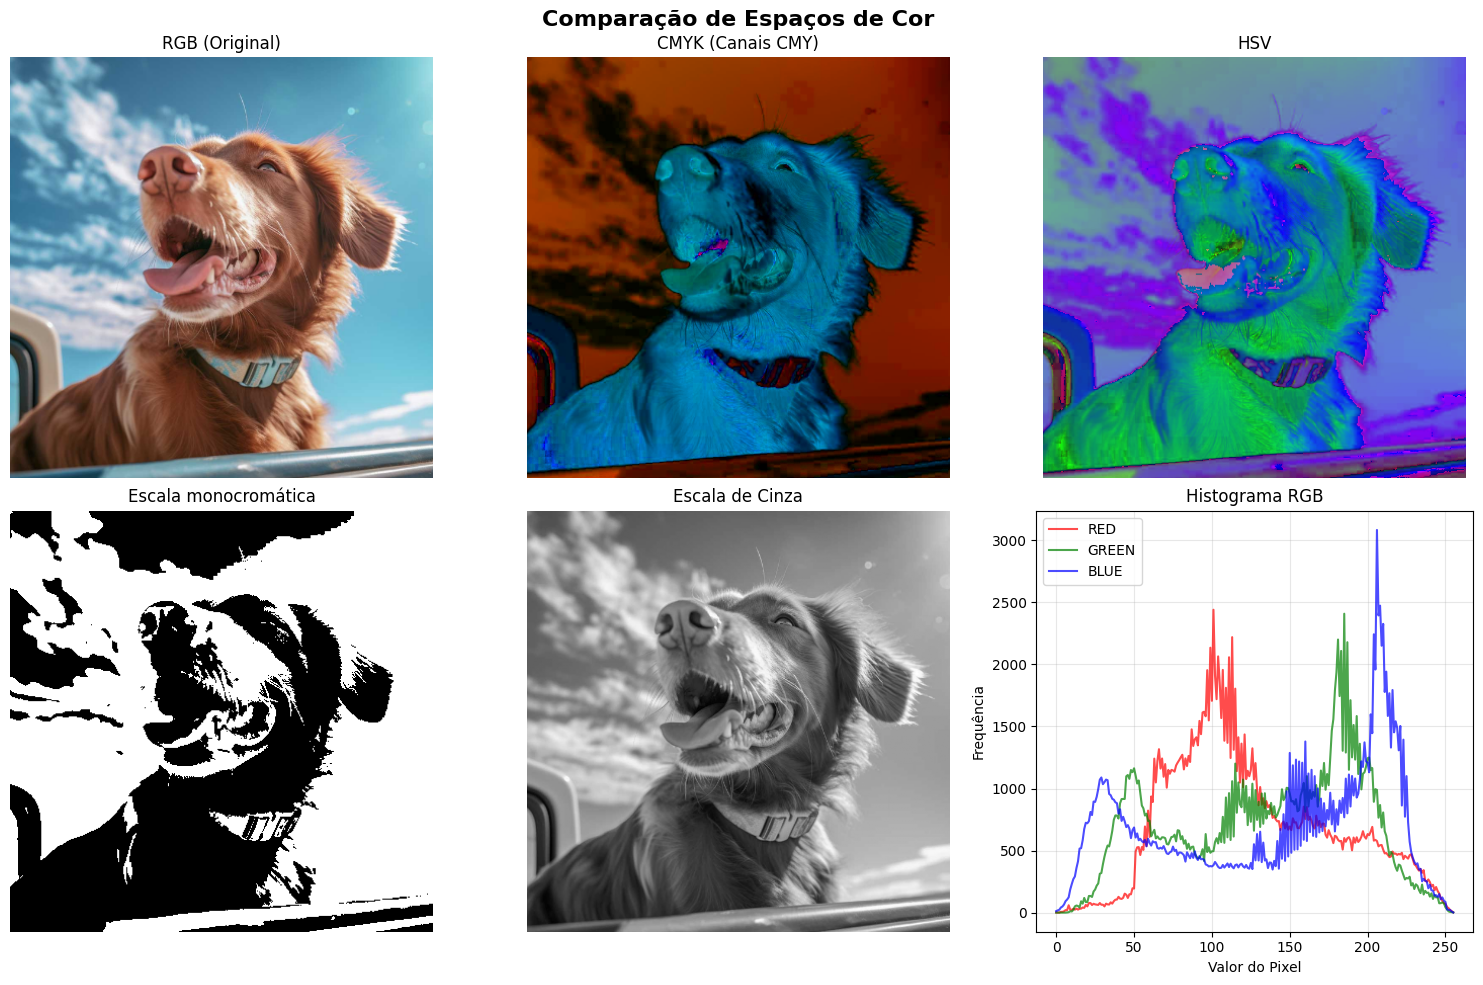


📋 MENU DE OPÇÕES:
1. Visualizar em diferentes espaços de cor
2. Visualizar canais de cor individuais
3. Converter e salvar em diferentes formatos
4. Análise completa de qualidade e compressão
5. Converter para espaço de cor específico
6. Carregar nova imagem
0. Sair

Escolha uma opção: 4

📊 Realizando análise completa...


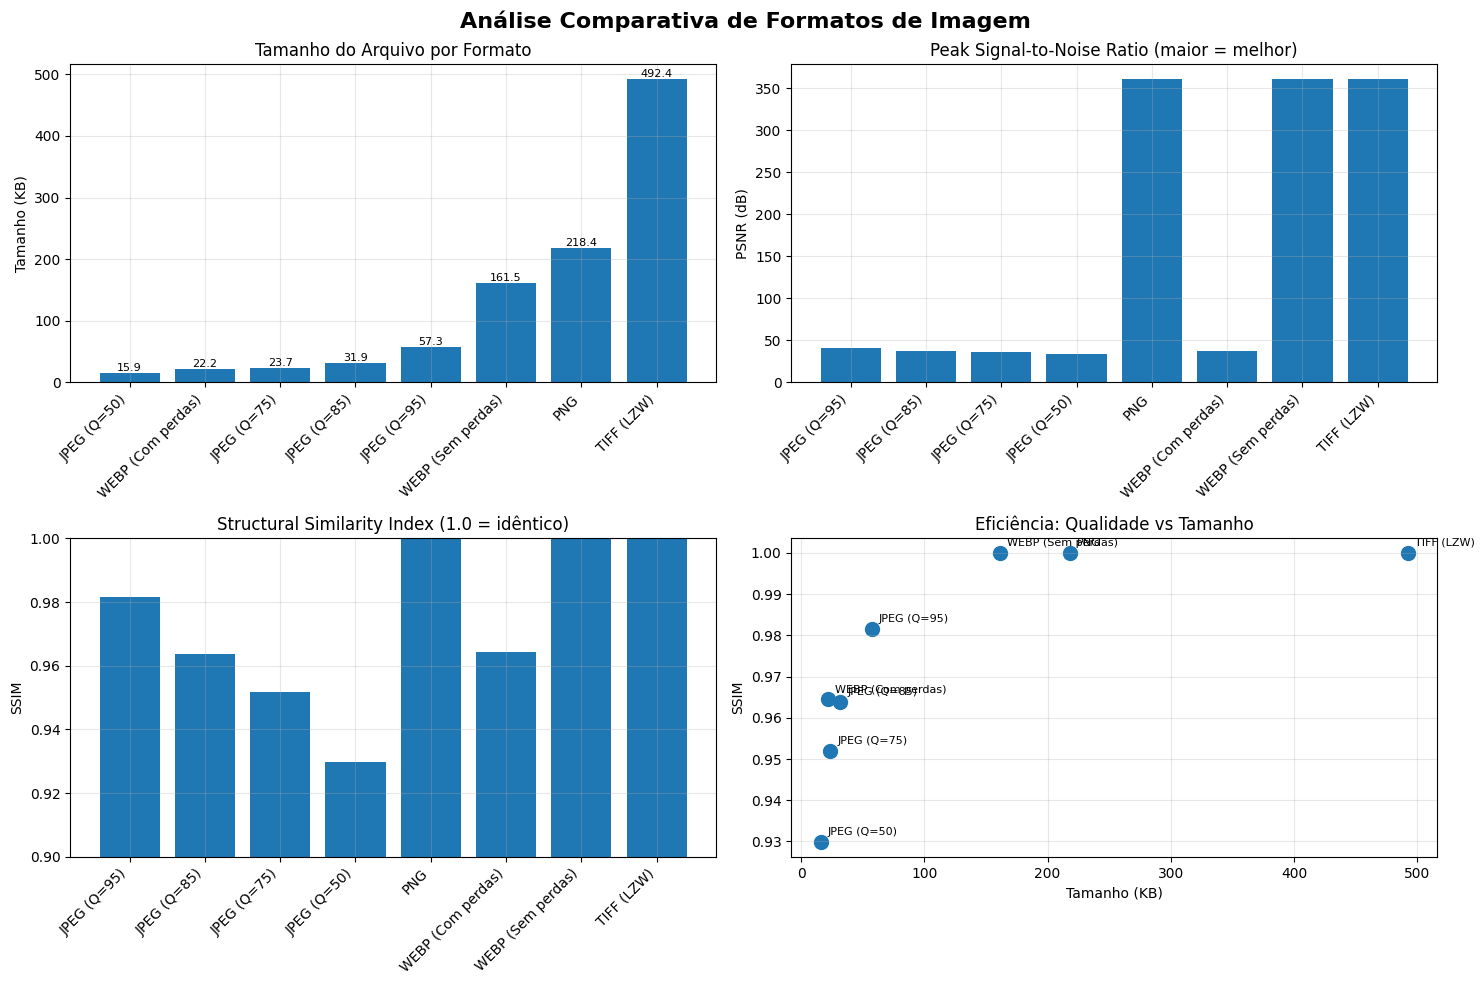


Deseja ver uma comparação visual detalhada? (s/n): 
s
Deseja focar em uma região específica? (s/n): 
n


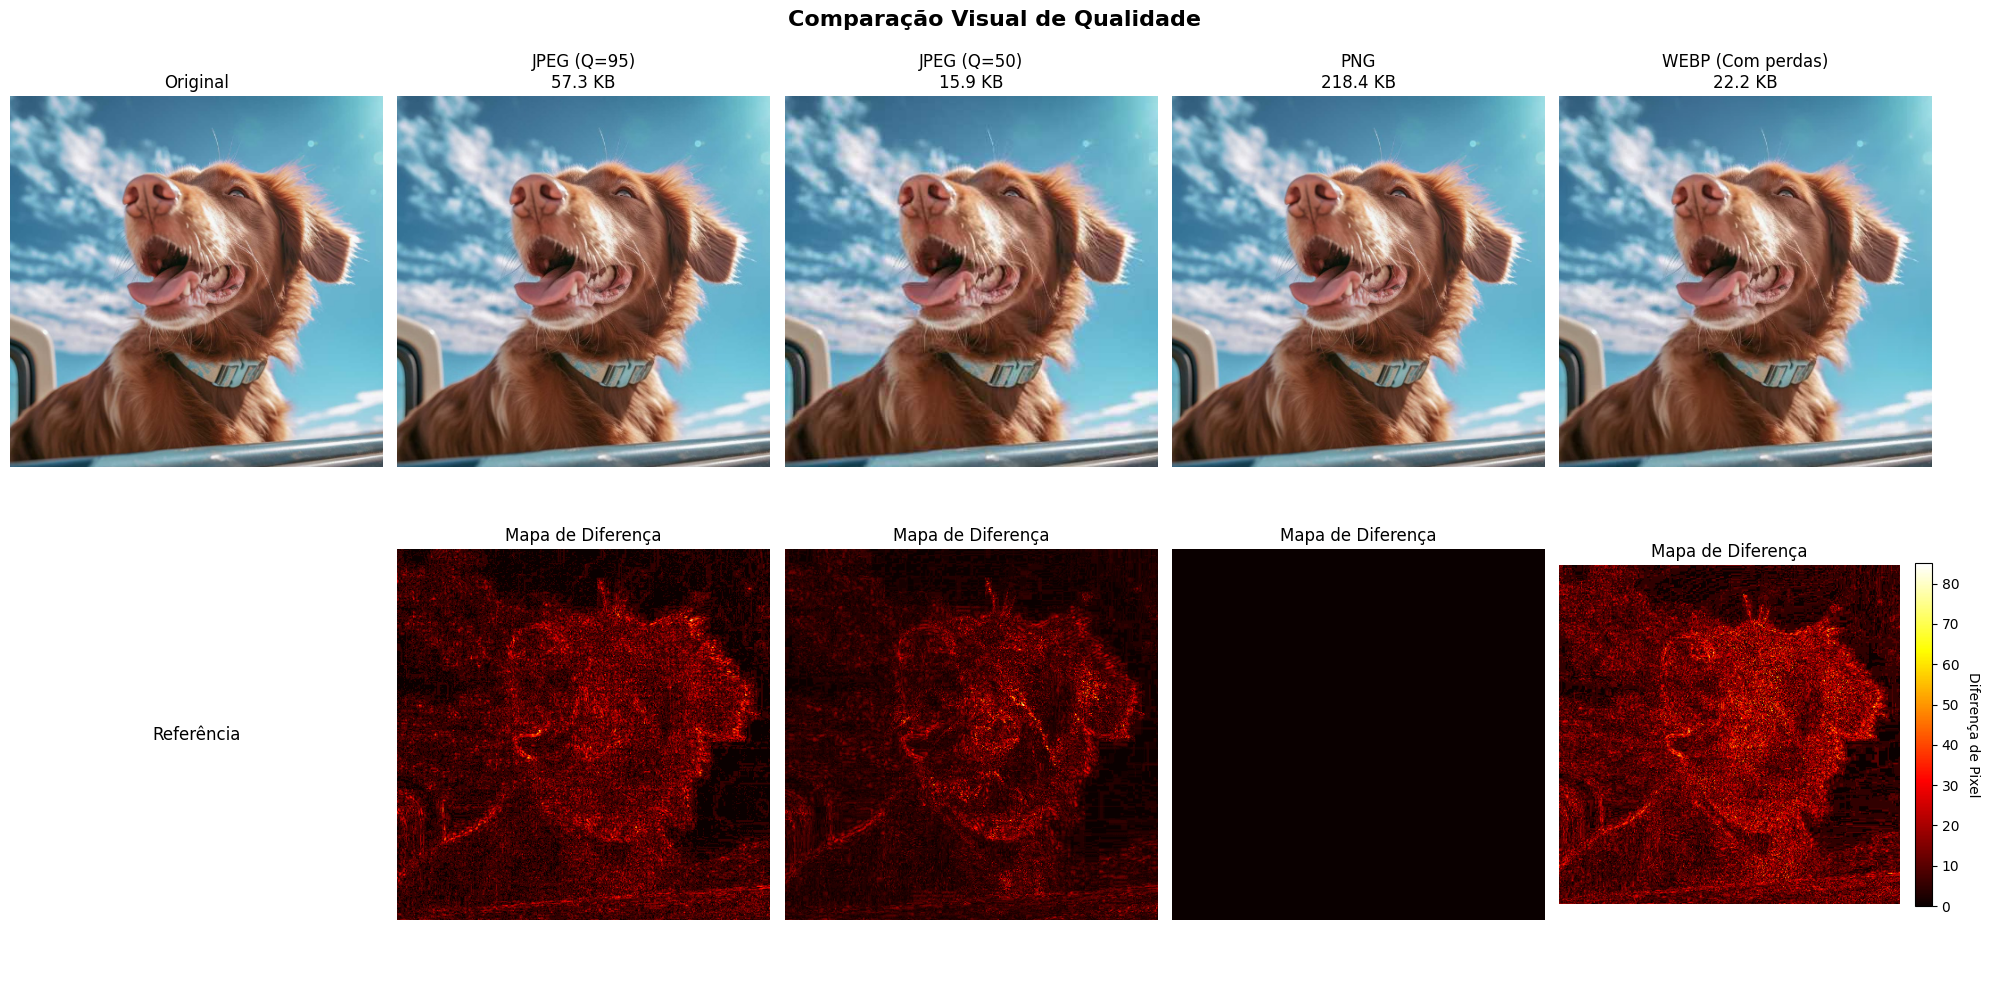


📈 RESUMO DA ANÁLISE:

Formatos por tamanho:
          Formato  Tamanho (KB)
      JPEG (Q=50)     15.876953
WEBP (Com perdas)     22.214844
      JPEG (Q=75)     23.708984
      JPEG (Q=85)     31.888672
      JPEG (Q=95)     57.283203
WEBP (Sem perdas)    161.523438
              PNG    218.396484
       TIFF (LZW)    492.365234

Métricas de qualidade:
          Formato  PSNR (dB)     SSIM
      JPEG (Q=95)  41.016861 0.981628
      JPEG (Q=85)  37.396791 0.963830
      JPEG (Q=75)  35.773515 0.951869
      JPEG (Q=50)  33.772863 0.929791
              PNG 361.201999 1.000000
WEBP (Com perdas)  37.839128 0.964432
WEBP (Sem perdas) 361.201999 1.000000
       TIFF (LZW) 361.201999 1.000000

📋 MENU DE OPÇÕES:
1. Visualizar em diferentes espaços de cor
2. Visualizar canais de cor individuais
3. Converter e salvar em diferentes formatos
4. Análise completa de qualidade e compressão
5. Converter para espaço de cor específico
6. Carregar nova imagem
0. Sair

Escolha uma opção: 0

👋 Encerran

In [301]:
def main_converter():
    """Interface principal do conversor"""
    print("🎨 CONVERSOR DE IMAGENS - ESPAÇOS DE COR E FORMATOS 🎨")
    print("="*60)

    # Upload da imagem
    image_path = upload_image()
    if not image_path:
        return

    # Exibir propriedades
    properties = get_image_properties(image_path)
    display_properties(properties)

    # Menu de opções
    while True:
        print("\n📋 MENU DE OPÇÕES:")
        print("1. Visualizar em diferentes espaços de cor")
        print("2. Visualizar canais de cor individuais")
        print("3. Converter e salvar em diferentes formatos")
        print("4. Análise completa de qualidade e compressão")
        print("5. Converter para espaço de cor específico")
        print("6. Carregar nova imagem")
        print("0. Sair")

        choice = input("\nEscolha uma opção: ")

        if choice == '1':
            print("\n🎨 Visualizando espaços de cor...")
            visualize_color_spaces(image_path)

        elif choice == '2':
            print("\nEscolha o espaço de cor:")
            print("1. RGB")
            print("2. CMYK")
            print("3. HSV")

            space_choice = input("Opção: ")
            spaces = {'1': 'RGB', '2': 'CMYK', '3': 'HSV'}

            if space_choice in spaces:
                visualize_color_channels(image_path, spaces[space_choice])
            else:
                print("Opção inválida!")

        elif choice == '3':
            print("\n💾 Salvando em diferentes formatos...")
            df_formats = save_in_formats(image_path)
            print("\n📊 Resultados da conversão:")
            print(df_formats.to_string(index=False))

            # Perguntar se deseja baixar os arquivos
            download = input("\nDeseja baixar os arquivos convertidos? (s/n): ")
            if download.lower() == 's':
                for _, row in df_formats.iterrows():
                    files.download(row['Arquivo'])

        elif choice == '4':
            print("\n📊 Realizando análise completa...")

            # Salvar em formatos
            df_formats = save_in_formats(image_path)

            # Calcular métricas
            compressed_paths = df_formats.to_dict('records')
            df_metrics = compare_quality_metrics(image_path, compressed_paths)

            # Visualizar comparações
            visualize_format_comparison(df_formats, df_metrics)

            # Comparação visual
            print("\nDeseja ver uma comparação visual detalhada? (s/n): ")
            if input().lower() == 's':
                print("Deseja focar em uma região específica? (s/n): ")
                if input().lower() == 's':
                    print("Digite as coordenadas (x y largura altura) separadas por espaço:")
                    try:
                        coords = list(map(int, input().split()))
                        if len(coords) == 4:
                            create_visual_quality_comparison(image_path, compressed_paths, region=coords)
                        else:
                            create_visual_quality_comparison(image_path, compressed_paths)
                    except:
                        create_visual_quality_comparison(image_path, compressed_paths)
                else:
                    create_visual_quality_comparison(image_path, compressed_paths)

            # Mostrar tabela resumida
            print("\n📈 RESUMO DA ANÁLISE:")
            print("\nFormatos por tamanho:")
            print(df_formats[['Formato', 'Tamanho (KB)']].sort_values('Tamanho (KB)').to_string(index=False))

            if not df_metrics.empty:
                print("\nMétricas de qualidade:")
                print(df_metrics[['Formato', 'PSNR (dB)', 'SSIM']].to_string(index=False))

        elif choice == '5':
            print("\nEscolha a conversão desejada:")
            print("1. RGB → CMYK")
            print("2. RGB → HSV")
            print("3. RGB → Escala de Cinza")
            print("4. RGB → RGBA")
            print("5. RGB → Escala monocromática")

            conv_choice = input("Opção: ")

            conversions = {
                '1': ('RGB', 'CMYK'),
                '2': ('RGB', 'HSV'),
                '3': ('RGB', 'GRAY'),
                '4': ('RGB', 'RGBA'),
                '5': ('RGB', 'MONOCHROME')
            }

            if conv_choice in conversions:
                from_space, to_space = conversions[conv_choice]

                # Carregar e converter
                img = Image.open(image_path).convert('RGB')
                img_array = np.array(img)

                converted = convert_color_space(img_array, from_space, to_space)

                # Salvar
                output_name = f"converted_{to_space.lower()}.png"

                if to_space == 'GRAY':
                    Image.fromarray(converted, mode='L').save(output_name)
                else:
                    Image.fromarray(converted).save(output_name)

                print(f"\n✅ Imagem convertida salva como: {output_name}")

                # Visualizar
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                ax1.imshow(img)
                ax1.set_title(f'Original ({from_space})')
                ax1.axis('off')

                if to_space == 'GRAY' or to_space == 'MONOCHROME':
                    ax2.imshow(converted, cmap='gray')
                else:
                    ax2.imshow(converted)
                ax2.set_title(f'Convertida ({to_space})')
                ax2.axis('off')

                plt.tight_layout()
                plt.show()

                # Baixar
                download = input("Deseja baixar a imagem convertida? (s/n): ")
                if download.lower() == 's':
                    files.download(output_name)

        elif choice == '6':
            image_path = upload_image()
            if image_path:
                properties = get_image_properties(image_path)
                display_properties(properties)

        elif choice == '0':
            print("\n👋 Encerrando o conversor. Até logo!")
            break

        else:
            print("\n❌ Opção inválida! Tente novamente.")

# Executar o conversor
if __name__ == "__main__":
    main_converter()